# Neural style transfer

This notebook is a documented learning experience in the topic of style transfer ai and neural networks.

The sources can be found at the bottom of this notebook.

## About Style Transfer

Style Transfering is the reprezentation of a given image using another image's art style as reference.
Here we have an example of my cat, stylized by an [existing style transer service](https://reiinakano.com/arbitrary-image-stylization-tfjs/).

Inputs:<br/>
<img src=".md/cat_input.jpg" alt="cat" width="200"/>
<img src=".md/style_input.jpg" alt="style" width="200"/>

Result:<br/>
<img src=".md/result.jpg" alt="result" width="210"/>

In the following chapters I will be attempting to recreate and improve upon this example using a neural style transer network created with [TensorFlow](https://www.tensorflow.org/).

## Setup

### Imports and some useful functions

In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

#To display images in the notebook
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

# Create an image from a tensor
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

# Define a function to load an image and limit its maximum dimension to 512 pixels.
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# Display image in the notebook
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

2022-10-18 15:19:20.041512: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-18 15:19:23.424367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 15:19:23.424441: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-18 15:19:23.851445: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-18 15:19:29.804249: W tensorflow/stream_executor/platform/de

### VGG19
Style transfer requires 2 neural networks, a trained feature extractor (also known as image classifier), and a transfer network.

The [guide](https://www.tensorflow.org/tutorials/generative/style_transfer) I'm following, recommends using a [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) model for feature extraction. Which is an image classification model of 19 layers, trained with thousands of images.

I will load the model and show the result of the classification of this image:

<img src=".md/cat_input.jpg" width="200"/>

The output will be a list of recognized objects in the image, if the pre-trained classifier model is working correctly.

In [2]:
content_image = load_img('.md/cat_input.jpg')

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224)) # VGG19 requires images to be 224x224
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

2022-10-18 15:19:35.187227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-18 15:19:35.188691: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-18 15:19:35.189028: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-18 15:19:35.189357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-18 15:19:35.189670: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

[('hamper', 0.1864334),
 ('shopping_basket', 0.041492),
 ('carton', 0.035847683),
 ('cradle', 0.033675622),
 ('sleeping_bag', 0.032497372)]

### Define content and style

As I previously mentioned, the [VGG19](https://keras.io/api/applications/vgg/#vgg19-function) model consists of 19 layers. These layers represent basic and composited features of the image in the following manner:<br>
The first few layers represent basic features like curves, edges, textures.<br>
As you look deeper in the network, the layers represent more and more complicated features of the image, like eyes, ears, or even a face.

Our model has the following layers:
 - input_4
 - block1_conv1
 - block1_conv2
 - block1_pool
 - block2_conv1
 - block2_conv2
 - block2_pool
 - block3_conv1
 - block3_conv2
 - block3_conv3
 - block3_conv4
 - block3_pool
 - block4_conv1
 - block4_conv2
 - block4_conv3
 - block4_conv4
 - block4_pool
 - block5_conv1
 - block5_conv2
 - block5_conv3
 - block5_conv4
 - block5_pool

Since all these layers represent different features in the image, we can define which should be used for style and which for content. This allow the network to extract only the defining features of the image.

In [3]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

Our pre-trained classifier model defines the input and output layers for us, so all we need to do is supply a `keras.Model` with them. Here we define a function which creates the keras Model using only the layers we specify.

Then we can use this model to get the values of the layers for a specific image.

In [4]:
def vgg_layers(layer_names):

  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

style_image = load_img('.md/style_input.jpg')

style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 462, 512, 64)
  min:  0.0
  max:  612.49725
  mean:  29.172327

block2_conv1
  shape:  (1, 231, 256, 128)
  min:  0.0
  max:  3813.098
  mean:  156.90674

block3_conv1
  shape:  (1, 115, 128, 256)
  min:  0.0
  max:  7351.9146
  mean:  199.74011

block4_conv1
  shape:  (1, 57, 64, 512)
  min:  0.0
  max:  17799.854
  mean:  658.20306

block5_conv1
  shape:  (1, 28, 32, 512)
  min:  0.0
  max:  2552.0264
  mean:  48.688652



These values can be used to calculate a [Gram Matrix](https://en.wikipedia.org/wiki/Gram_matrix) for each layer, which can represent the layer's style.

We use the following function for calculating a Gram Matrix:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

which can be implemented concisely using the `tf.linalg.einsum` function:

In [5]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content

This class will build a model that returns the style and content tensors.

In [6]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:

In [7]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.006396208
    max:  19508.416
    mean:  332.7687

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  48189.723
    mean:  8970.164

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  193460.28
    mean:  8509.669

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2394980.8
    mean:  129696.58

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  76117.125
    mean:  1061.7584

Contents:
   block5_conv2
    shape:  (1, 32, 23, 512)
    min:  0.0
    max:  1291.1721
    mean:  13.581427


## Run gradient descent

We now have an extractor that can return the style and content data of the image separately. With these, we can merge the two layers onto the original image through a gradient descent optimizing algorithm, which tries to minimize differences between the given image and the targets. To do this we calculate the mean square error for the image's output relative to the style and content targets, and take the weighted sum of these losses.

In [8]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# The image we will be working on
image = tf.Variable(content_image)

# Since this is a float image, define a function to keep the pixel values between 0 and 1
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# For now we are using the Adam optimiser, but LBFGS supposedly has better results.
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [9]:

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [10]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

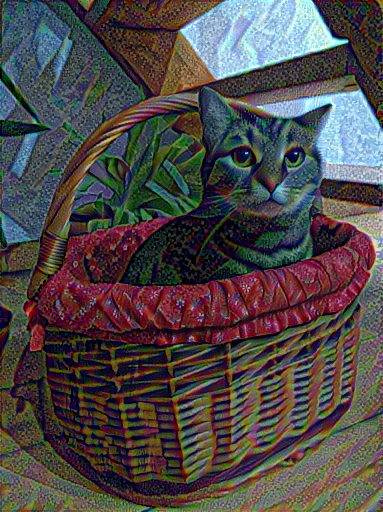

In [11]:
for n in range(10):
    train_step(image)

tensor_to_image(image)

## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. We can decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

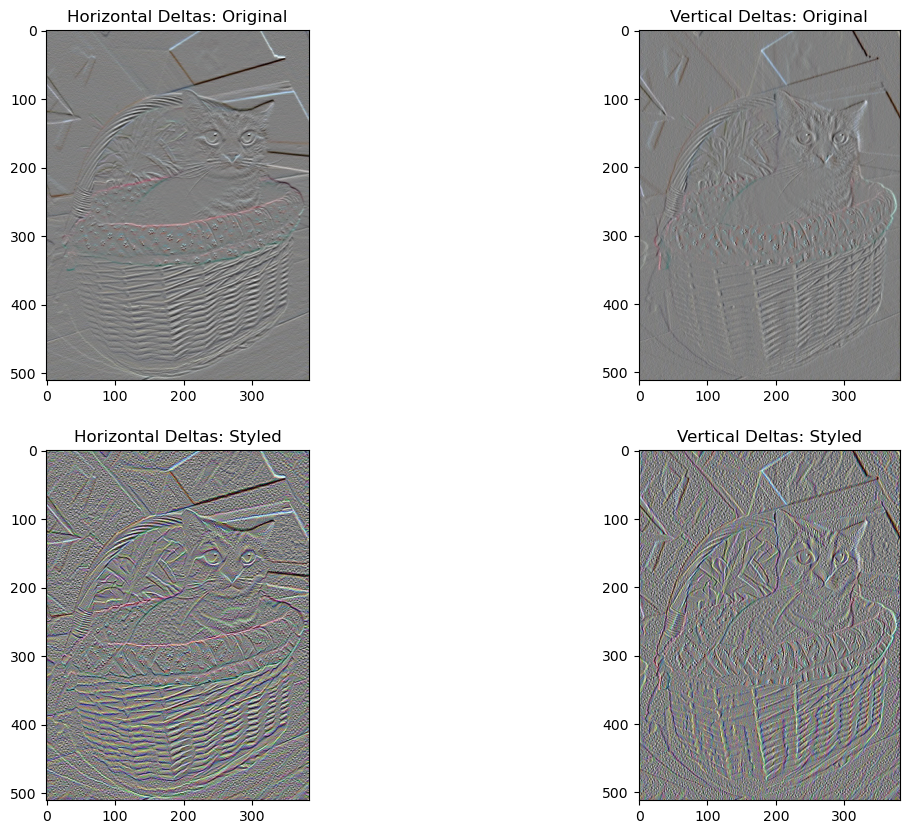

In [12]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]


  return x_var, y_var
  
x_deltas, y_deltas = high_pass_x_y(content_image)
noise_level = 2

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(noise_level*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(noise_level*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(noise_level*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(noise_level*x_deltas+0.5), "Vertical Deltas: Styled")

The regularization loss associated with this is the sum of the squares of the values:

In [15]:
# Definition for calculating total variation loss:
#def total_variation_loss(image):
#  x_deltas, y_deltas = high_pass_x_y(image)
#  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))



tf.image.total_variation(image).numpy()


array([73837.91], dtype=float32)

## Re-run the optimization

Choose a weight for the `total_variation_loss`:

In [20]:
total_variation_weight=100

Now include it in the `train_step` function:

In [17]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Reinitialize the image-variable and the optimizer:

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

And run the optimization:

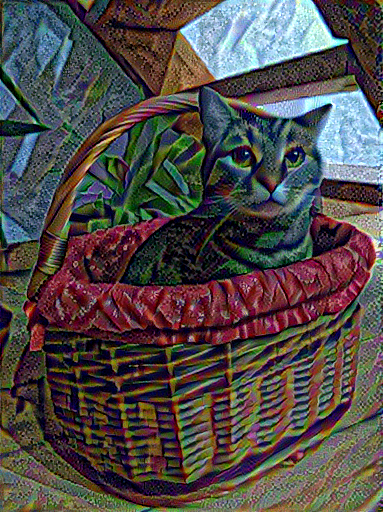

Train step: 10
Total time: 21.8


In [21]:
import time
start = time.time()

epochs = 1
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

# References
These are the pages I've used to learn about the subject.
 - https://www.tensorflow.org/tutorials/generative/style_transfer
 - https://keras.io/api/
 - https://arxiv.org/pdf/1409.1556.pdf
 - https://www.fritz.ai/style-transfer/
 - https://en.wikipedia.org/wiki/Gram_matrix
 - https://en.wikipedia.org/wiki/Gradient_descent